<a href="https://colab.research.google.com/github/ANLandge/prey_predator_agents/blob/main/prey_predator_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Agent Based Modeling in Python**

Steps 
1. Think about your system. Figure out your agents. Catagorise them. List their properties. List their interactions.
2. Write down the equations that dscribe your system with the parameters and the assumptions. 
3. Clearly define the aim of mathematical modeling. What would be your inputs? What will be the output? How will you visualize/analyze the results.
4. Write down the structure of your code. How many classes do you need? What methods should these classes have?
5. Write the code. Test the code. Debug. Repeat. 




**System desciption:**

The system consists of organisms. Some are prey and others are predators. Both types can reproduce, and die. Preadtors eat the prey and then the prey is dead. Predators reproduce when there is sufficient prey and other predators are present neayby for mating. They preys reproduce at a constant rate. 

 The prey-predator system can be described by the classical lotka-volterra system of equations - 
(Ref. - Shim, H. & Fishwick, P. A. doi:10.1016/B978-008045405-4.00225-1.)

 Predator = Fox = F

 Prey = Rabbit = R

 The **assumptions** are 
 1. Rabbits reproduce at a rate dependent on current rabbit population (exponential growth). 
 2. Foxes die at a rate dependent on current fox population (exponential decay/death).
 3. Rabbits are eaten by foxes at rate dependent on both rabbit and fox populations.
 4. Foxes reproduce at rate dependent on both rabbit and fox populations. 
 
 The **parameters** are - 
* a - rabbit birth rate constant
* b - rabbit death rate constant
* c - fox birth rate constant
* d - fox death rate constant


 This gives us the **equations**- 

* *dR/dt = a X R - b X F X R* 

* *dF/dt = c X F X R - d X F*

Aims:
1. To simulate the spatiotemporal dynamics of the system

2. To visualize the pre-predator interactions and population change over time

3. To Test model behaviour at different parameters, initial conditions, etc. 

4. To have some fun



In [42]:
"""
This program provides classes and methods to simulate a simple agent-based
predator-prey model.

"""
# import the necessary packages

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import time
import os
from IPython import display

%matplotlib inline 
# use matplotlib inline mode to disply plots

class organism(object):
    """
    A general class that contains all the agents.
    """
    def __init__(self, id, type, sz, rng):
        self.type= type # 'prey' or 'predator'
        self.id=str(id).zfill(4)  # each agent gets an id
        self.name=type+self.id # and a name
        a=np.random.randint(0,sz) # a random x-coordinate
        b=np.random.randint(0,sz) # a random y-coordinate
        self.pos=np.array([a,b]) # initial position of the agent
        self.rng = rng # the range of the agent

class simulateModel(object):
    """
    This class contains methods to update the system state
    """
    def __init__(self, steps, outdir, landSize, initial_prey, initial_predator, rngPre, rngPrd, a, b, c, d):
        self.steps=steps 
        self.sz = landSize # the size of the landscape where the organisms live
        self.outdir= outdir
        self.preyCnt = initial_prey
        self.prdCnt = initial_predator
        self.rngPre = rngPre 
        self.rngPrd= rngPrd
        self.a = a # prey birth rate
        self.b = b # prey death rate
        self.c = c # predator birth rate
        self.d = d # predator death rate
        self.cntDict={} # a dictionary to store prey and predator counts
        self.cntDict['prey']= [self.preyCnt]
        self.cntDict['predator']= [self.prdCnt]

    def initialize(self, ):
        """
        This function initializes the model with given number of preys and predators and adds them to a list. 
        """
        self.orgList=[]
        for i in range(self.preyCnt):
            ag= organism(i,'prey', self.sz, self.rngPre)
            self.orgList.append(ag)

        for i in range(self.prdCnt):
            ag = organism(i, 'predator', self.sz, self.rngPrd)
            self.orgList.append(ag)

    def getNeighbours(self,ag):
        """
        This function checks who is in the vicinity of the given agent. 
        output:
        [1,1] if prey and predator is nearby
        [1,0] only prey is near
        [0,1] only predator is near
        [0,0] nobody is closeby
        """
        self.neighbours = [0,0]

        for agN in self.orgList:
            if agN.name != ag.name: # to look only for agents other than the given agent
                x1,y1 = ag.pos
                x2,y2 = agN.pos
                dist = np.sqrt((x2-x1)**2 + (y2-y1)**2) # compute euclidean distance
                if dist<=ag.rng:
                    if agN.type=='prey':
                        self.neighbours[0] = 1
                    elif agN.type=='predator':
                        self.neighbours[1] = 1
            if self.neighbours==[1,1]:
                break

    def update(self,step):
        """
        The logic - at each step
        1. the prey reproduces with probability 'a' 
        2. the prey dies with probability 'b' (if a predator is nearby)
        3. the predator reproduce with probability 'c' (if a prey is nearby)
        4. the predator dies at probability 'd' 

        """
        for ag in self.orgList:
            self.getNeighbours(ag) # first see who is nearby

            if ag.type=='prey':  # the logic for prey
                # if self.neighbours[0]==1:
                self.doIt = np.random.choice([0,1], p=[1-self.a, self.a]) # applying the probability
                if self.doIt:
                    # add new prey
                    agN = organism(self.preyCnt,'prey', self.sz, self.rngPre)
                    self.orgList.append(agN) 
                    self.preyCnt+=1 

                if self.neighbours[1]==1:
                    self.doIt = np.random.choice([0,1], p=[1-self.b, self.b])
                    if self.doIt:
                        # the prey gets eaten 
                        self.orgList.remove(ag) 
                        self.preyCnt-=1 

            elif ag.type=='predator':
                if self.neighbours[0]==1:
                    self.doIt = np.random.choice([0,1], p=[1-self.c, self.c])
                    if self.doIt:
                        # the predator reproduces
                        agN = organism(self.prdCnt,'predator', self.sz, self.rngPrd)
                        self.orgList.append(agN) 
                        self.prdCnt+=1 

                # if self.neighbours==[0,1]:
                self.doIt = np.random.choice([0,1], p=[1-self.d, self.d])
                if self.doIt:
                    # the predator dies
                    self.orgList.remove(ag) # remove organism from the list
                    self.prdCnt-=1 #decrease prdCnt by 1

        #update prey and predator counts
        self.cntDict['prey'].append(self.preyCnt)
        self.cntDict['predator'].append(self.prdCnt)

    def plotAgents(self, step):
        """
        This function makes the plots of prey and predator distribution and counts.
        """
        plt.clf()
        display.clear_output(wait=True)

        plt.subplot(1,2,1) # to show the distribution
        plt.title(f"step_{step}")
        plt.xticks([])
        plt.yticks([])
        plt.xlim(0,self.sz)
        plt.ylim(0,self.sz)
        
        for ag in self.orgList:
            if ag.type=="prey":
                plt.plot(ag.pos[0], ag.pos[1], 'o', color='k')
            elif ag.type=="predator":
                plt.plot(ag.pos[0], ag.pos[1], 'x', color='b')
            else:
                None
      
        plt.subplot(1,2,2) # to show the counts
        plt.xlabel("Step number")
        plt.ylabel("Counts")

        xAx = np.linspace(0,step+1,step+2)
        plt.plot(xAx, self.cntDict['prey'], '-', color='k', label='prey')
        plt.plot(xAx, self.cntDict['predator'], '-', color='b', label='predator')    
        plt.legend()
        
        display.display(plt.gcf())        
        
        outName = self.outdir/f"agentsAt_{step}.tif"
        # plt.savefig(outName)
    




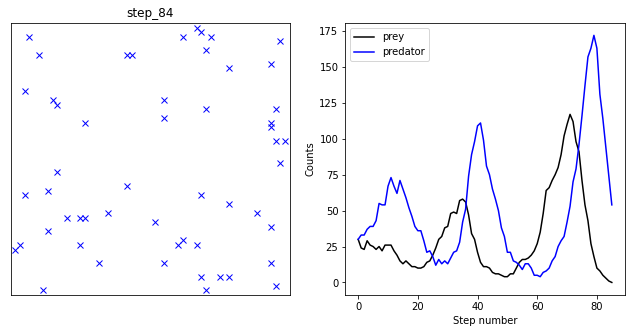

All preys died.
Program completed in 0Hr:0Min:43sec



In [45]:
print("\n**************************************************** \nStarting the simulation program...")
t1 = time.time()

#make directory to store the results
cwdPath=Path(os.path.abspath(os.getcwd()))

#get the current date and time to create a unique directory for each simulation
now=datetime.now()
datetime_str=(now.strftime("%Y%m%d_%H%M%S_"))

dirName=str(datetime_str+"prey_predator")
outdir=cwdPath/'data'/dirName
outdir.mkdir(mode=0o777, parents=True, exist_ok=True)

print("Created directory for results ...")

# define parameters
alpha=0.2
beta=0.8
delta=0.6
gamma=0.4

steps = 100
landSize = 60
initial_prey= 30
initial_predator = 30
rngPre = 4
rngPrd = 10

# populate the land with some organisms
print("Running simulation ...")
sim1 = simulateModel(steps, outdir, landSize, initial_prey, initial_predator, rngPre, rngPrd,
  alpha, beta, delta, gamma)

sim1.initialize()

# update the population
plt.figure(figsize= [11, 5])

for step in range(steps):
    sim1.update(step)
    sim1.plotAgents(step)

    if sim1.preyCnt==0:
        print("All preys died.")
        break

    if sim1.prdCnt==0:
        print("All predators died.")
        break

    if sim1.preyCnt>1000:
        print(f"Maximum prey capacity reached. prey count = {sim1.preyCnt}")
        break

    if sim1.prdCnt>1000:
        print(f"Maximum predator capacity reached. predator count = {sim1.prdCnt}")
        break
plt.close()

t2= time.time()
totalSec= t2-t1
Sec=int(totalSec%60)
Hrs=int(totalSec//3600)
Min=int((totalSec%3600)//60)

print ("Program completed in %sHr:%sMin:%ssec\n"%(Hrs,Min,Sec))